In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from HullWhite import HullWhite
from scipy.optimize import fsolve
beta = np.array([1.879892, 0.579211, 	3.993992, 1.445091])
tau  = np.array([ 16.633491, 	0.319680])
reversion=0.08670264780833303 #0.13949636660880768
volatility=0.013928489964789946 #0.017793899652989272
HW = HullWhite(initial=0.02459103, reversion=reversion, volatility=volatility, b=beta, tau=tau)
 

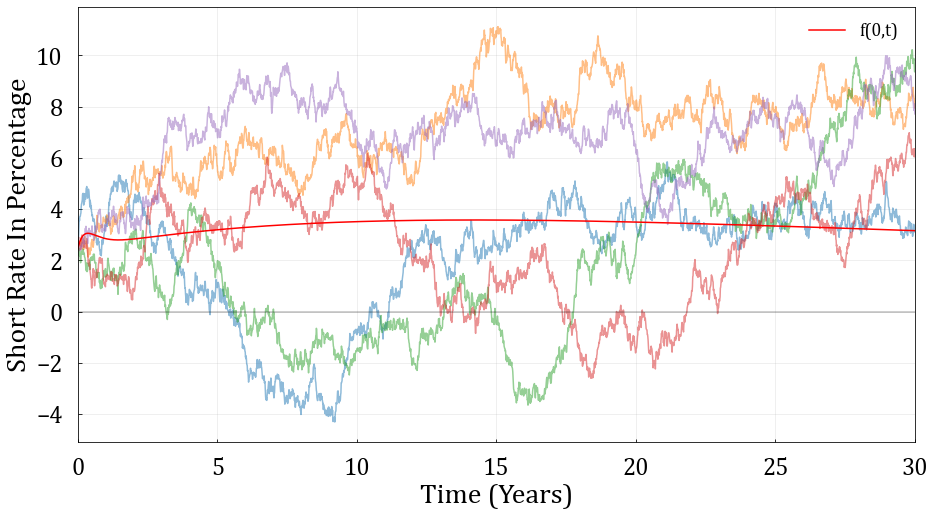

In [4]:
plt.rc('font',family='Cambria')
fig, ax = plt.subplots()
for i in range(5):
    time, float = HW.create_path(1/100,30, fwd=10, seed=i)
    sns.lineplot(x=time, y=float*100, alpha=0.5)
sns.lineplot(x=time, y=[HW.forwardCurve(t, beta, tau)*100 for t in time], color='red', label='f(0,t)')   
# sns.lineplot(x=time, y=[HW.expectedRate(t)*100 for t in time], color='blue', label='E[r(t)]')   

fig.set_size_inches(15,8)

ax.set_xlabel('Time (Years)', fontname="Cambria", fontsize = 28)
ax.set_ylabel('Short Rate In Percentage', fontname="Cambria", fontsize = 28)
ax.tick_params(axis='x', direction='in', right = 'True', labelsize = 24, pad = 15)
ax.tick_params(axis='y', direction='in', top = 'True', labelsize = 24, pad = 15)
ax.axhline(y=0, color='k', alpha = 0.25)
ax.set_xlim(0,30)
plt.grid(alpha = 0.25)
plt.xticks(np.arange(0, 35, 5))
plt.legend(frameon = False, fontsize = 18, loc='upper right')
plt.savefig('./Graphs/SimPathExample.png', bbox_inches='tight')

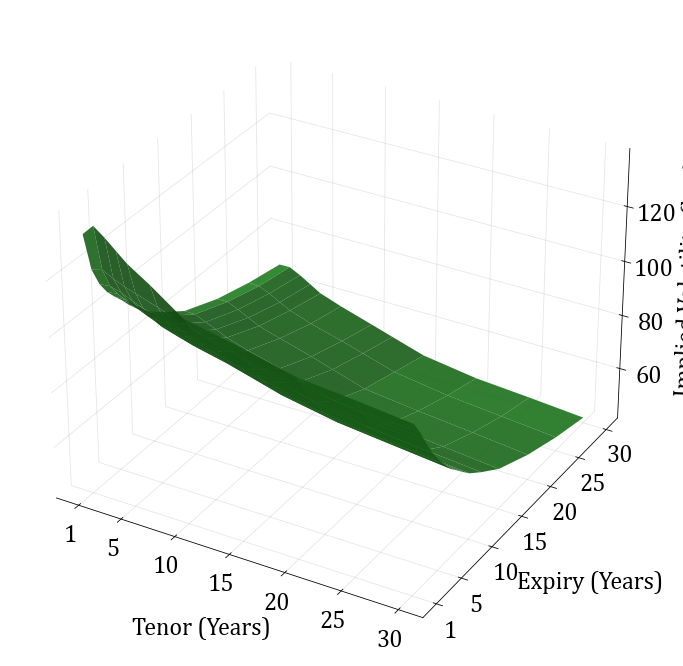

In [5]:
import pandas as pd

file_path   = 'bvolmatrix.xlsx'
sheet       = 'STRADDLE'
sheetf      = 'STRIKE'
sheeti      = 'BVOL'
df          = pd.read_excel(file_path, sheet_name=sheet,header=None)
dff         = pd.read_excel(file_path, sheet_name=sheetf,header=None)
dfi         = pd.read_excel(file_path, sheet_name=sheeti,header=None)
straddlesobs       = pd.DataFrame(df[[x for x in np.arange(4,16)]][3:22])
strikes            = pd.DataFrame(dff[[x for x in np.arange(4,16)]][3:22])
impliedVol         = pd.DataFrame(dfi[[x for x in np.arange(4,16)]][3:22])
straddlesobs.index     = df[1][3:22].values
strikes.index          = dff[1][3:22].values
impliedVol.index       = dfi[1][3:22].values
straddlesobs.index.name='Expiry'
strikes.index.name     ='Expiry'
impliedVol.index.name  ='Expiry' 
straddlesobs.columns   = [int(x) for x in df.iloc[1][4:16].values]
strikes.columns        = [int(x) for x in dff.iloc[1][4:16].values]
impliedVol.columns     = [int(x) for x in dfi.iloc[1][4:16].values]
# straddlesobs
sheeta      = 'ARTICLE'
dfff        = pd.read_excel(file_path, sheet_name=sheeta,header=None)
articleobs  = dfff[[x for x in np.arange(4,17)]][3:17]/10000
articleobs.index = dfff[1][3:17].values
articleobs.index.name = 'Expiry'
articleobs.columns = [int(x) for x in dfff.iloc[1][4:17].values]

straddlesobs=straddlesobs.iloc[4::,0::]
strikes = strikes.iloc[4::,0::]
impliedVol = impliedVol.iloc[4::,0::]

def monthoryear(x):
    if x<12:
        return f'{int(x)}M'
    else:
        return f'{int(x/12)}Y'
    

# X,Y = np.meshgrid(straddlesobs.columns/12, straddlesobs.index/12)
# fig = plt.figure(figsize=(16,16))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(Y,X,straddlesobs.values)
# ax.set_xlabel('Expiry')
# ax.set_xticks((straddlesobs.index/12))
# ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
# ax.set_ylabel('Tenor')
# ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
# ax.set_yticks(straddlesobs.columns/12)
# ax.invert_xaxis()
# plt.show()

# fig = plt.figure(figsize=(8,8))
# X,Y = np.meshgrid(impliedVol.columns/12, impliedVol.index/12)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(Y,X,impliedVol.values, alpha=0.9, color='red')

# ax.set_xlabel('Expiry')
# ax.set_xticks((straddlesobs.index/12))
# ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
# ax.set_ylabel('Tenor')
# ax.set_yticks(straddlesobs.columns/12)
# ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
# ax.invert_xaxis()
# plt.show()

plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)

fig = plt.figure(figsize=(12,12))
X,Y = np.meshgrid(impliedVol.columns/12, impliedVol.index/12)


ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,impliedVol.values, alpha=0.9, color='limegreen')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticks((1, 5, 10, 15, 20, 25, 30))
#ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
#ax.set_xticklabels([int(x/12) for x in straddlesobs.index])
ax.set_zlabel('Implied Volatility')
ax.zaxis.labelpad=-0.7
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticks((1, 5, 10, 15, 20, 25, 30))
ax.tick_params(labelsize=24, pad = 5, direction = 'out')
#ax.tick_params(axis='y', labelsize=24, pad = 5)
ax.tick_params(axis='z', labelsize=24, pad = 10)
#ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
#ax.set_yticklabels([int(x/12) for x in straddlesobs.columns])

#Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(30, 300)

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
#Labelling
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)

ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 40
ax.zaxis.labelpad = 20

ax.set_xlabel('Tenor (Years)', fontsize = 24, rotation = 0)
ax.set_ylabel('Expiry (Years)', fontsize = 24, rotation = 0)
ax.set_zlabel('Implied Volatility (bps)', fontsize = 24)
bbox = fig.bbox_inches.from_bounds(0, 1.25, 12, 9.5)

plt.savefig(f'./Graphs/Implied_Volatility.png', bbox_inches=bbox)

In [6]:
straddlesobs

,12,24,36,48,60,84,120,144,180,240,300,360
Expiry,,,,,,,,,,,,
12,0.010752,0.011071,0.010830,0.010552,0.010277,0.009871,0.009192,0.009070,0.008867,0.008497,0.008346,0.008174
24,0.013589,0.013703,0.013483,0.013296,0.013149,0.012856,0.012383,0.012164,0.011795,0.011363,0.011125,0.010977
36,0.015670,0.015721,0.015569,0.015322,0.015101,0.014816,0.014332,0.014066,0.013601,0.013090,0.012865,0.012612
48,0.017333,0.017410,0.017124,0.016893,0.016684,0.016325,0.015782,0.015441,0.014911,0.014327,0.014022,0.013681
60,0.018740,0.018732,0.018434,0.018121,0.017847,0.017445,0.016872,0.016475,0.015902,0.015254,0.014865,0.014487
72,0.019882,0.019853,0.019501,0.019108,0.018778,0.018336,0.017756,0.017320,0.016673,0.015968,0.015543,0.015113
84,0.020701,0.020690,0.020202,0.019770,0.019501,0.019005,0.018433,0.017963,0.017245,0.016453,0.015985,0.015529
96,0.021405,0.021423,0.020934,0.020532,0.020198,0.019695,0.019061,0.018557,0.017774,0.016928,0.016450,0.015996
108,0.022113,0.022081,0.021576,0.021222,0.020834,0.020238,0.019532,0.018977,0.018149,0.017277,0.016782,0.016298


In [7]:
from scipy.optimize import minimize, basinhopping, fsolve
def HullWhiteOptimizer(reversion,volatility, observedP, observedK):
    if volatility <= 0:
        print('Volatility is negative')
        return 100000, 100000
    straddleModel = observedP.copy()
    optHW = HullWhite(initial=0.02459103, 
                      reversion=reversion,
                      b = np.array([1.879892, 0.579211, 	3.993992, 1.445091]),
                      tau  = np.array([ 16.633491, 	0.319680]),
                      volatility=volatility)
    for expiry in observedP.index:
        # Expiry first
        # Getting the right expiry and converting to years
        
        for tenor in observedP.columns:
            # Creating tenor legs
            T = np.arange(expiry/12, expiry/12+tenor/12+0.5, 0.5)
            S = np.arange(expiry/12, expiry/12+tenor/12+1)
            # Finding the ATM fixed rate
            K = observedK[tenor].loc[expiry]/100
            # K = fsolve(lambda x: optHW.swap(0, S, T, x), x0=MarketATM)[0]

            #Calculating the payer and receiver swpt price
            p = optHW.swaption(0,Te=expiry/12, S=S,T=T, K=K, payer=True)
            r = optHW.swaption(0,Te=expiry/12, S=S, T=T, K=K, payer=False)
            
            #Normalizing w.r.t. to the A(t,S) function (2.10) everythin you wanna know...
            A = np.array([optHW.marketZCB(Si) for Si in S[1::]]).sum()

            straddleModel[tenor].loc[expiry] = (p+r)/A
            # if (p+r)*10000<0:
            # print(p,r,expiry,tenor,reversion,volatility)
            

    error = ((straddleModel/observedP-1)**2).sum().sum()
    # print(f'{error}', end='                                                         \r')
    return error,straddleModel

In [8]:
Nfeval = 0
def callback(xk):
    global Nfeval
    print(f'Eval: {Nfeval}, x={(xk[0],xk[1])}, func: {HullWhiteOptimizer(xk[0], xk[1], observedP=straddlesobs, observedK=strikes)[0]}')
    Nfeval += 1
    return True
# callback([0.027832947, 0.11874695, 0.019677])

result = minimize(
    fun = lambda x: HullWhiteOptimizer(reversion=x[0], volatility=x[1], observedP=straddlesobs, observedK=strikes)[0],
    x0  = np.array([0.08670264780833303 ,0.013928489964789946]),
    # bounds = [(0.1,20),(1e-04,0.5), (1e-04, 0.1)],
    method='nelder-mead',
    tol = 1e-4,
    callback=callback
)

Eval: 0, x=(0.08670264780833303, 0.013928489964789946), func: 1.1003843691156008
Eval: 1, x=(0.08670264780833303, 0.013928489964789946), func: 1.1003843691156008
Eval: 2, x=(0.08670264780833303, 0.013928489964789946), func: 1.1003843691156008
Eval: 3, x=(0.08788803557133759, 0.01404818792542486), func: 1.0993241590625409
Eval: 4, x=(0.08821825073388886, 0.014001940986088642), func: 1.0988424583757295
Eval: 5, x=(0.08940363849689342, 0.014121638946723558), func: 1.0987263375528789
Eval: 6, x=(0.08834949009336437, 0.014054988945915479), func: 1.0983805616421594
Eval: 7, x=(0.08854740751450887, 0.01404512746620408), func: 1.0983722525247357
Eval: 8, x=(0.08854740751450887, 0.01404512746620408), func: 1.0983722525247357
Eval: 9, x=(0.08854310783791317, 0.014060238483606676), func: 1.0982929414986322
Eval: 10, x=(0.08854310783791317, 0.014060238483606676), func: 1.0982929414986322
Eval: 11, x=(0.08854310783791317, 0.014060238483606676), func: 1.0982929414986322
Eval: 12, x=(0.08854310783791

In [9]:
0.0886064203173911-0.08670264780833303, 0.014062728344514077-0.013928489964789946

(0.0019037725090580715, 0.00013423837972413068)

In [10]:
import matplotlib.colors as colors
import matplotlib.cm as cm
rev=0.08670264780833303#result.x[0]
vol=0.013928489964789946#result.x[1]
fittedHW = (HullWhiteOptimizer(reversion=rev ,volatility=vol, observedP=straddlesobs, observedK=strikes)[1]/straddlesobs-1)
colorss = ['midnightblue','darkblue','mediumblue','royalblue','darkcyan','lightseagreen','mediumaquamarine','mediumseagreen','limegreen','yellowgreen','greenyellow','chartreuse','yellow','gold','orange']
col = []
for c in colorss:
    list = [c]*12
    col.extend(list)

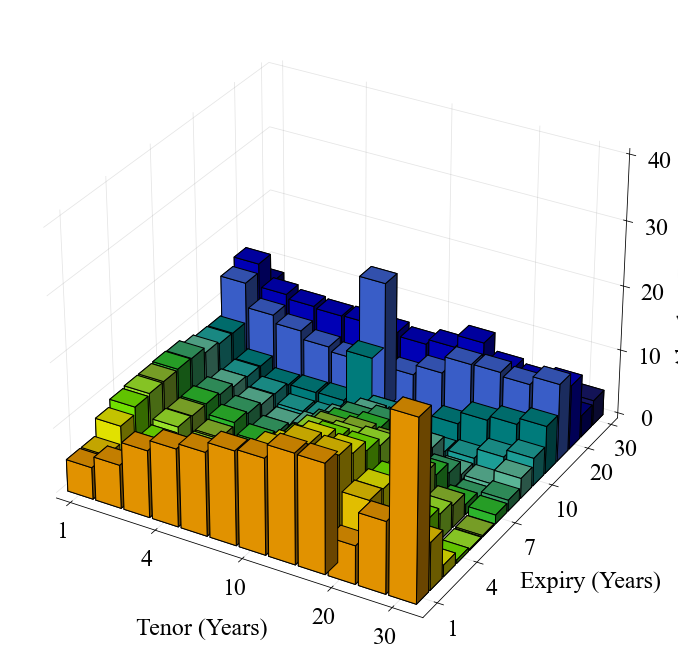

In [11]:
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)
plt.rc('font',family='Times New Roman')
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
xpos,ypos = np.meshgrid(np.arange(12)+1, np.arange(15)+1)
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.9*np.ones_like(zpos)
dz = np.abs(fittedHW.values).ravel()
#newstuff

#ax.invert_xaxis()
#ax.invert_yaxis()
ax.view_init(30, 300)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=col[::-1], alpha = 1, edgecolor = 'black')

#Ticks to match years
ax.set_xticks([1.25, 4.25, 7.25, 10.25, 12.25])
ax.set_xticklabels([1, 4, 10, 20, 30])
ax.set_yticks([1.75, 4.75, 7.75, 10.75, 13.75, 15.75])
ax.set_yticklabels([1, 4, 7, 10, 20, 30])
ax.set_zticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_zticklabels([0, 10, 20, 30, 40])
ax.set_xlim(1,13)
ax.set_ylim(1,16)
ax.set_zlim(0,0.4)

ax.tick_params(labelsize=24, pad = 5, direction = 'out')
#ax.tick_params(axis='y', labelsize=24, pad = 5)
ax.tick_params(axis='z', labelsize=24, pad = 10)
#ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
#ax.set_yticklabels([int(x/12) for x in straddlesobs.columns])

#Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(30, 300)

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
#Labelling
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)

ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 40
ax.zaxis.labelpad = 20

ax.set_xlabel('Tenor (Years)', fontsize = 24, rotation = 0)
ax.set_ylabel('Expiry (Years)', fontsize = 24, rotation = 0)
ax.set_zlabel('Absolute Error (%)', fontsize = 24)

bbox = fig.bbox_inches.from_bounds(0, 1.25, 12, 9.5)
plt.savefig(f'./Graphs/Calibration_Errors.png', bbox_inches=bbox)

In [23]:
def HullWhiteOptimizerOne(rev, volatility,expiry, tenor, observedP, observedK):
    if volatility <= 0:
        print('Volatility is negative             ',end='\r')
        return 100000
    straddleModel = observedP.copy()
    optHW = HullWhite(initial=0.02748672, 
                      reversion=rev,
                      b = np.array([1.879892, 0.579211, 	3.993992, 1.445091]),
                      tau  = np.array([ 16.633491, 	0.319680]),
                      volatility=volatility)

    # Creating tenor legs
    T = np.arange(expiry/12, expiry/12+tenor/12+0.5, 0.5)
    S = np.arange(expiry/12, expiry/12+tenor/12+1)
    # Finding the ATM fixed rate
    K = observedK[tenor].loc[expiry]/100
    # K = fsolve(lambda x: optHW.swap(0, S, T, x), x0=MarketATM)[0]

    #Calculating the payer and receiver swpt price
    p = optHW.swaption(0,Te=expiry/12, S=S,T=T, K=K, payer=True)
    r = optHW.swaption(0,Te=expiry/12, S=S, T=T, K=K, payer=False)
    
    #Normalizing w.r.t. to the A(t,S) function (2.10) everythin you wanna know...
    A = np.array([optHW.marketZCB(Si) for Si in S[1::]]).sum()

    straddle = (p+r)/A
    # if (p+r)*10000<0:
    # print(p,r,expiry,tenor,reversion,volatility)
            

    error = abs((straddle/observedP[tenor].loc[expiry]-1))
    # print(f'{error}', end='                                                         \r')
    return error

In [24]:
impVolHW = impliedVol.copy()
impRevHW = impliedVol.copy()
errors = impliedVol.copy()

for tenor in impVolHW.columns:
    for expiry in impVolHW.index:
        print(f'\nExpiry: {expiry}, Tenor: {tenor}                     ', end='\r')
        res = minimize(
            lambda x: HullWhiteOptimizerOne(x[0], x[1], expiry, tenor, observedP=straddlesobs, observedK=strikes),
            x0=[result.x[0], result.x[1]],
        )
        impRevHW[tenor].loc[expiry] = res.x[0]
        impVolHW[tenor].loc[expiry] = res.x[1]
        errors[tenor].loc[expiry] = HullWhiteOptimizerOne(res.x[0],res.x[1], expiry, tenor, observedP=straddlesobs, observedK=strikes)


Expiry: 12, Tenor: 12                     
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Expiry: 360, Tenor: 12                     
Expiry: 12, Tenor: 24                     
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Vol

c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Expiry: 12, Tenor: 120                     
Expiry: 24, Tenor: 120                     


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Expiry: 12, Tenor: 144                     
Expiry: 24, Tenor: 144                     


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Expiry: 12, Tenor: 180                     


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                     


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                     
Volatility is negative                     


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Volatility is negative                     
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


[Text(1.0, 0, '1Y'),
 Text(2.0, 0, '2Y'),
 Text(3.0, 0, '3Y'),
 Text(4.0, 0, '4Y'),
 Text(5.0, 0, '5Y'),
 Text(7.0, 0, '7Y'),
 Text(10.0, 0, '10Y'),
 Text(12.0, 0, '12Y'),
 Text(15.0, 0, '15Y'),
 Text(20.0, 0, '20Y'),
 Text(25.0, 0, '25Y'),
 Text(30.0, 0, '30Y')]

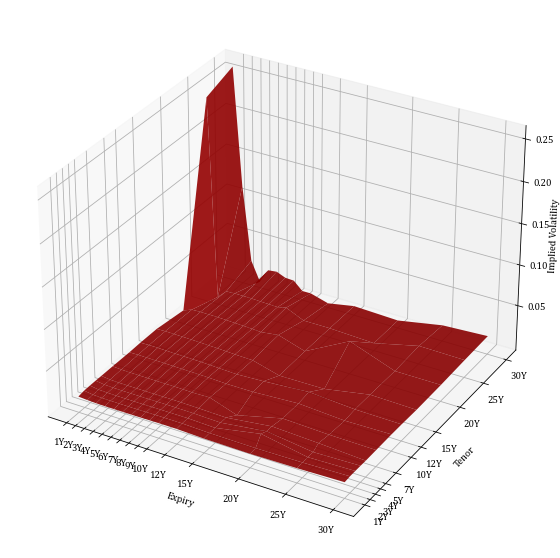

In [25]:
fig = plt.figure(figsize=(10,10))
X,Y = np.meshgrid(impVolHW.columns/12, impliedVol.index/12)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,impVolHW.values, alpha=0.9, color='red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.zaxis.labelpad=-0.7
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])

[Text(1.0, 0, '1Y'),
 Text(2.0, 0, '2Y'),
 Text(3.0, 0, '3Y'),
 Text(4.0, 0, '4Y'),
 Text(5.0, 0, '5Y'),
 Text(7.0, 0, '7Y'),
 Text(10.0, 0, '10Y'),
 Text(12.0, 0, '12Y'),
 Text(15.0, 0, '15Y'),
 Text(20.0, 0, '20Y'),
 Text(25.0, 0, '25Y'),
 Text(30.0, 0, '30Y')]

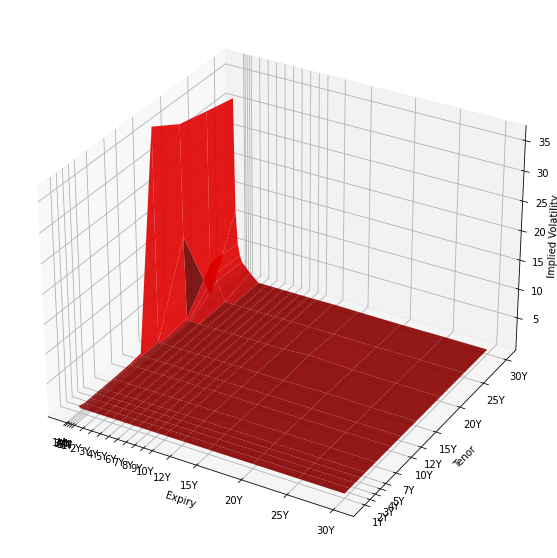

In [44]:
fig = plt.figure(figsize=(10,10))
X,Y = np.meshgrid(impVolHW.columns/12, impliedVol.index/12)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,impRevHW.values, alpha=0.9, color='red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.zaxis.labelpad=-0.7
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])

[Text(1.0, 0, '1Y'),
 Text(2.0, 0, '2Y'),
 Text(3.0, 0, '3Y'),
 Text(4.0, 0, '4Y'),
 Text(5.0, 0, '5Y'),
 Text(7.0, 0, '7Y'),
 Text(10.0, 0, '10Y'),
 Text(12.0, 0, '12Y'),
 Text(15.0, 0, '15Y'),
 Text(20.0, 0, '20Y'),
 Text(25.0, 0, '25Y'),
 Text(30.0, 0, '30Y')]

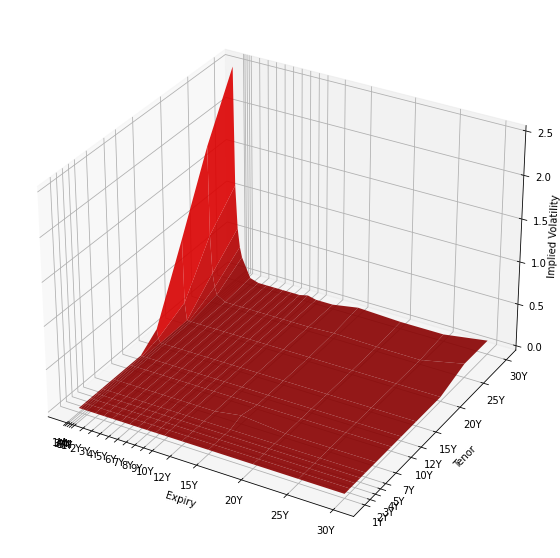

In [45]:
fig = plt.figure(figsize=(10,10))
X,Y = np.meshgrid(impVolHW.columns/12, impliedVol.index/12)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,errors.values, alpha=0.9, color='red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.zaxis.labelpad=-0.7
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])

<AxesSubplot: >

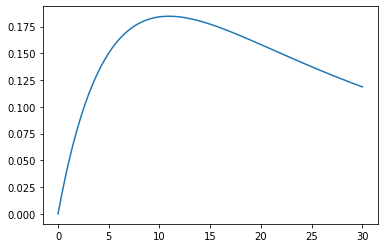

In [39]:
time, float = HW.create_path(1/12, 30, 0)
HW = HullWhite(initial=0.02748672, 
                      reversion=0.13, 
                      kappa=0.1001, 
                      b = np.array([1.879892, 0.579211, 	3.993992, 1.445091]),
                      tau  = np.array([ 16.633491, 	0.319680]),
                      volatility=0.05)
sns.lineplot(x=time, y=[HW.marketZCB(t)-HW.ZCB(0,t) for t in time])
# sns.lineplot(x=time, y=[HW.ZCB(0,t) for t in time])

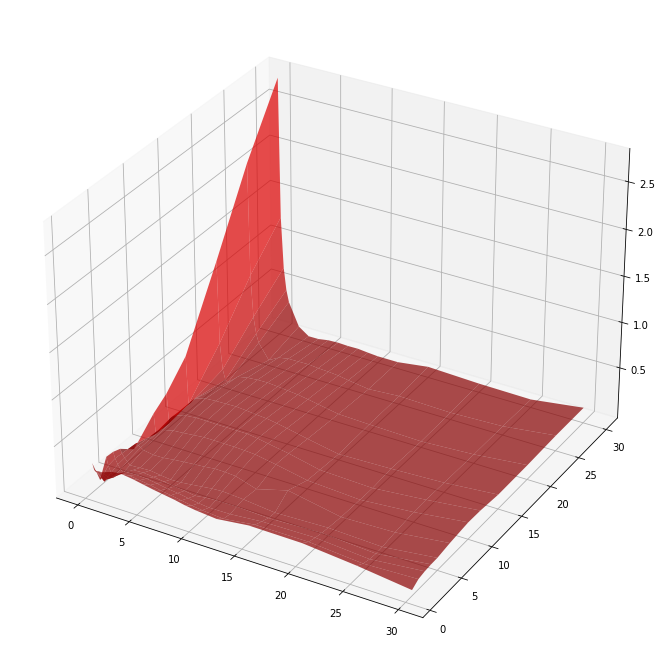

In [51]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111, projection='3d')

X,Y = np.meshgrid(straddlesobs.columns/12, straddlesobs.index/12)
ax1.plot_surface(Y,X,straddlesobs.values, alpha=0.7, color='blue')

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,fittedHW.values, alpha=0.7, color='red')



ax1.set_xlabel('Expiry')
ax1.set_xticks((straddlesobs.index/12)[::-1])
ax1.set_ylabel('Tenor')
ax1.set_yticks(straddlesobs.columns/12)
ax1.invert_xaxis()

# ax1 = fig.add_subplot(111, projection='3d')


plt.show()

<AxesSubplot: >

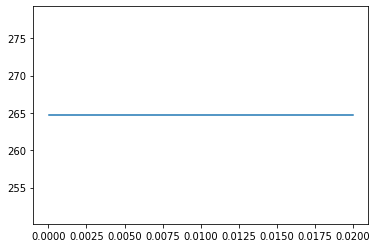

In [99]:
sns.lineplot(x=np.linspace(0.00001,0.02,10), y=[HullWhiteOptimizer(reversion=0.88 ,volatility=vol, observedP=straddlesobs, observedK=strikes)[0] for vol in np.linspace(0.00001,0.02,10)])